---
title: "Cat Vs Dog Classfier" 
categories: [fastai, deep-learning]
jupyter: python3
execute:
  freeze: true
  output: false  # For cells that don't need output shown
  echo: true
toc: true
toc-depth: 4
number-sections: true
format:
  html:
    toc-expand: false
---

# Setup and Training

The first step is to install necessary dependencies and setup my environment.
In my case the fastai toolbox as well as a search engine API.
In chapter 2, bing search was the one used. Alas, that got deprecated in the meantime, so I am going to use duckduckgo search another free search API.

In [ ]:
# Clean up previous folders
!rm -rf animal

# Install latest fastai + fastcore + fastbook
!pip install -U fastai fastcore fastbook ddgs

import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
from fastbook import *
from fastai.vision.widgets import *
from ddgs import DDGS
import time, random
from pathlib import Path

# 1. Collect data
animals = ["cat", "dog"]
path = Path('animals')  # Path to store images

if not path.exists():
    path.mkdir()

for animal in animals:
    dest = (path/animal)
    dest.mkdir(exist_ok=True)
    with DDGS() as ddg:
        results = [r for r in ddg.images(f'{animal}', max_results=100)]  # Search for cat or dog images
        # Extract content URLs from the result dictionaries
        urls = [r.get('image') or r.get('contentUrl') for r in results if r.get('image') or r.get('contentUrl')]
        # Random delay to avoid spamming the server
        time.sleep(random.uniform(1, 3))
        # Download the images
        download_images(dest, urls=urls)

In [ ]:
# List results
fns = get_image_files(path)
print(len(fns))

184


Now that the process of collecting data is over, we need to check if any are corrupted. By corrupted, we usually refer to files that return an error when trying to open them.
An image or file is corrupted when:
* Downloaded incompletly
* Subject to network tranmission errors
* Storage or memory issues
* File-system or server-side problems  and if that's the case clean them.

To check for integrity, we use the `verify_images` function.
This will return a collection object that has a `map` method which calls the passed function onto each element of the collection.
In this case it's the `unlink` function that will handle the cleaning of corrupted files.

In [ ]:
failed = verify_images(fns)
print(failed)
failed.map(Path.unlink);

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


[Path('animals/cat/d97e5771-40d9-4a1e-b1a3-849a32bca85a.jpg'), Path('animals/dog/743b109f-0222-4cc2-b1aa-fa95f3811185.jpg'), Path('animals/dog/fddc2b23-6712-4803-838d-81729f8efef5.jpg'), Path('animals/dog/3c41c6ee-858c-4b6d-9660-fbacab718d1c.jpg'), Path('animals/dog/c517196a-abde-49a6-b28c-35c4980dd228.jpg'), Path('animals/dog/f5b15c94-0dc4-4c75-b7f7-7cb7c3cc8854.jpg'), Path('animals/dog/97123c37-6e78-4ee9-9e8c-f1b85314e046.jpg'), Path('animals/dog/684ef9f1-9b6e-4154-bf3f-a077657ed265.jpg'), Path('animals/dog/d0fb283f-eee8-40f2-a1da-6195368eb85e.jpg')]


Now that we have our dataset, it's time to split it into `train`, `validation` and `test` sets.
* Training Set: Used to teach the model.

* Validation Set: Used during development to tune model settings (hyperparameters) and check generalization.

* Test Set: Used only at the end to fairly evaluate final model performance on unseen data.

Without separate sets, the model (or developers) might overfit—performing well on known data but poorly on new data.
The test set ensures honest, unbiased evaluation and helps prevent self-deception or vendor manipulation.

Keep in mind that data is usually biased, and if that's not taken into consideration, your model will end up equally biased.

To achieve that we use a `DataLoader` on each set and a thin super class `DataLoaders` to combine them all.

DataLoaders created successfully!


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


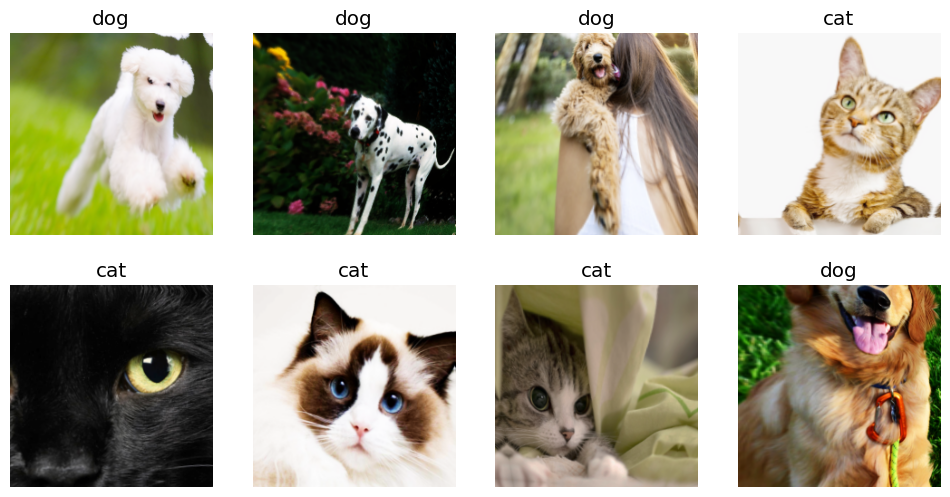

In [ ]:
# 3. Define the DataBlock
catVsDog = DataBlock(
    blocks=(ImageBlock, CategoryBlock),                 # Image = input, Category = output
    get_items=get_image_files,                          # Collect all image file paths
    splitter=RandomSplitter(valid_pct=0.2, seed=42),    # 80/20 train/val split
    get_y=parent_label,                                 # Label = name of parent folder (e.g. 'cat' or 'dog')
    item_tfms=RandomResizedCrop(224, min_scale=0.5),    # Resize and crop images
    batch_tfms=aug_transforms(mult=2)                   # Augmentations like flip, rotate, etc.
)

# 4. Create DataLoaders
try:
    dls = catVsDog.dataloaders(path)
    print("DataLoaders created successfully!")

    # Show a sample batch to verify everything works
    dls.show_batch(max_n=8)

    # 5. Create learner with resnet18 and track error rate
    learn = vision_learner(dls, resnet18, metrics=error_rate)

    # 6. Train the model for 4 epochs with fine-tuning
    learn.fine_tune(4)

except Exception as e:
    print(f"Error creating DataLoaders: {e}")
    print("This might be due to remaining corrupted images. Let's do a more thorough cleanup...")

The train and validation losses seem alright. But we still need to see where exactly our errors are occuring.

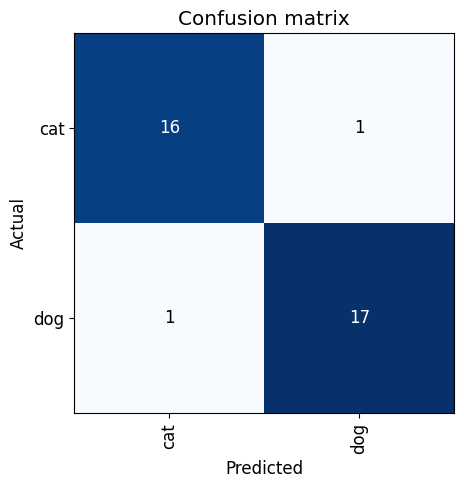

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

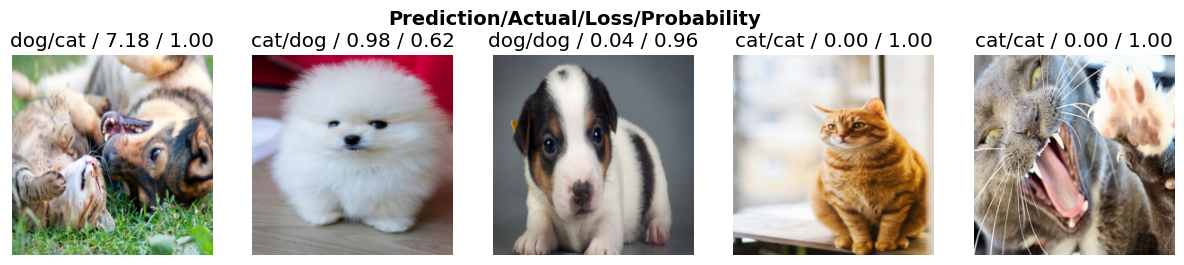

In [ ]:
interp.plot_top_losses(5, nrows=1)

There is clearly an image where I have both animals but labelled as `cat` so I choose `<Delete>`.
As for the small doggo being mistaken for a cat, work hazard I suppose.

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Let's re-train for another epoch or two now that the data is cleaned.

In [ ]:
# We keep the same transforms etc.
dls = catVsDog.dataloaders(path)
print("DataLoaders created successfully!")

# Re-create learner with resnet18 and track error rate
learn = vision_learner(dls, resnet18, metrics=error_rate)

# Train the model for 4 epochs with fine-tuning
learn.fine_tune(4)

DataLoaders created successfully!


# Turning the model into a web application

Once the model fine tuned, it's time to save it so it can be used in production.

In [ ]:
learn.export("CatVsDog.pkl")

In [ ]:
# Make sure the model is correctly saved
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('CatVsDog.pkl')]

Time to use this inference learned in a web application.
For that I opted for gradio for fast showcasing.
In the book, however they used [voila](https://github.com/voila-dashboards/voila) along with jupyter notebook for deployment.

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
from fastai.vision.all import *

# Load your model
learn = load_learner('CatVsDog.pkl')  # Your Fastai model

# Define prediction function
def predict(img):
    pred_class, pred_idx, probs = learn.predict(img)
    return {learn.dls.vocab[i]: float(probs[i]) for i in range(len(probs))}

# Build interface
interface = gr.Interface(fn=predict, inputs=gr.Image(type="pil"), outputs=gr.Label())
interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5a4164b39b6b8cac0b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip show fastai torch torchvision

Name: fastai
Version: 2.8.2
Summary: fastai simplifies training fast and accurate neural nets using modern best practices
Home-page: https://github.com/fastai/fastai
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: cloudpickle, fastcore, fastdownload, fastprogress, fasttransform, matplotlib, packaging, pandas, pillow, pip, plum-dispatch, pyyaml, requests, scikit-learn, scipy, spacy, torch, torchvision
Required-by: fastbook
---
Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nv

# Notes on Development & Deployment

While working on this first post, I encountered and resolved several challenges worth documenting.

##  Development Environment

Initially, all development—including model training and testing—was done in a Google Colab notebook. I wanted to preserve the cell outputs from that session to accurately reflect the training process in the final blog post. This meant converting the Colab notebook into a Quarto .qmd file without re-executing the code during rendering, so outputs would remain intact.

To prevent code re-execution, I added the following to both the YAML header of the .qmd file and the global Quarto configuration:

```{yml}
title: Title
jupyter: python3
execute:
  freeze: true
```

However, using `quarto convert my-notebook.ipynb` didn’t preserve the output cells as expected.
A reliable workaround was to first convert the notebook to Markdown:

```shell
jupyter nbconvert my-notebook.ipynb --to markdown --output converted-notebook.qmd
```

Then, I renamed the file to `.qmd` and manually added the necessary YAML header.

## Cross-Platform Path Handling
Another issue arose when I attempted to run the exported model on my local Windows machine. Since the model was trained in a Unix environment, it used `PosixPath` internally (via `pathlib`), which led to this error on Windows:

```sh
NotImplementedError: cannot instantiate 'PosixPath' on your system
```
To resolve this, I patched `PosixPath` to `WindowsPath` during model loading:

```{python}
import platform
from pathlib import Path
if platform.system() == 'Windows':
    import pathlib
    pathlib.PosixPath = pathlib.WindowsPath
```

## Version Matching for Reproducibility

For consistent predictions, ensure your local environment mirrors the dependency versions used during model training—particularly for `fastai`, `torch`, and `torchvision`.

## Deployment to Hugging Face Spaces with Docker
When deploying the Gradio app to Hugging Face Spaces, things weren't so straight-forward as I had assumed:

### Python Version Mismatch
The model was trained using Python 3.11, but Hugging Face Spaces (non-Docker) currently run on Python 3.10 by default. Rather than downgrading and retraining the model to match the runtime, I opted to use a Docker-based Space, which gave me full control over the environment and allowed me to use Python 3.11 inside the container.

### Incompatible Dependency Resolution
As previously mentionned, I used uv for installing dependencies locally. However, uv pulls from a newer, more bleeding-edge index than Hugging Face's default build environment supports. This led to version conflicts and build failures on Hugging Face. Switching back to a traditional pip-based requirements.txt and installing dependencies during the Docker build step solved this issue.

### Pickle Compatibility with load_learner()
The FastAI load_learner() function relies on Python’s pickle module, insecure by design.
For future applications, the correct process would be:
1. Separately save model weights and architecture
  ```{python}
  learn.export(fname='model-arch.pkl')
  learn.save('weights')
  ```

2. For deployment, recreate the learner explicitly then load weights
  ```{python}

  def build_learner(weights_path='weights', img_size=224):
    # Define the path to your model weights (should be in the same folder or passed explicitly)
    path = Path()

    # Recreate the DataLoaders (only needed to get vocab, transforms, etc.)
    # You can use a dummy set of images or pass a stub list if not using full data
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=Resize(img_size),
    )

    # You don't need real images for inference; a fake DataLoader works
    dummy_path = path / "inference_dummy"
    dummy_path.mkdir(exist_ok=True)
    (dummy_path / "cat").mkdir(exist_ok=True)
    # You can skip adding actual images if just doing `.load()` + `.predict()`

    dls = dblock.dataloaders(dummy_path, bs=1)

    # Rebuild the model architecture
    learn = vision_learner(dls, resnet34, pretrained=False)

    return learn
  
  learn = build_learner()
  learn.load('weights')
  ```